In [1]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
#os.chdir('/Users/ndnguyen20/gtfparse/')
from gtfparse import read_gtf
#os.chdir('/Users/ndnguyen20/Box/BCM_SMART/')
from tqdm import tqdm
import time
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
from functools import partial
#import multiprocessing.Pool as pool
#multiprocessing.Pool()._processes

This script tried to understand the capture coverage of gene transcripts across human genome

In [2]:
#export data from TCGA gencode v22
gencode_data = read_gtf('gencode.v22.annotation.gtf')
gencode_data.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'tag', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_status,transcript_name,tag,transcript_support_level,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,,,,,,,,,,
1,chr1,HAVANA,transcript,11869,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,basic,1,OTTHUMT00000362751.1,,,,,
2,chr1,HAVANA,exon,11869,12227,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,basic,1,OTTHUMT00000362751.1,1,ENSE00002234944.1,,,
3,chr1,HAVANA,exon,12613,12721,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,basic,1,OTTHUMT00000362751.1,2,ENSE00003582793.1,,,
4,chr1,HAVANA,exon,13221,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,basic,1,OTTHUMT00000362751.1,3,ENSE00002312635.1,,,


In [3]:
#just arrange chromosomes in order
chr_names = np.array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',\
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',\
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',\
       'chrX', 'chrY', 'chrM'])

In [4]:
#copy and modify from GENCODE_CAPTURE_mismatches

class GENCODE():
    def __init__(self, chr_name):
        self.chr_name = gencode_data[gencode_data.seqname==chr_name]

GENCODE_dict_chr={}
for chr_name in chr_names:
    chr_data = GENCODE(chr_name).chr_name
    chr_data.reset_index(drop= True, inplace = True)
    GENCODE_dict_chr[chr_name] = chr_data

In [5]:
GENCODE_genes = {}
GENCODE_exons = {}
for name in chr_names:
    GENCODE_genes[name] = GENCODE_dict_chr[name][GENCODE_dict_chr[name].feature=='gene']
    GENCODE_genes[name].sort_values(by = ['start'], axis = 0, inplace= True)
    GENCODE_genes[name].reset_index(drop=True, inplace=True)
    
    GENCODE_exons[name] = GENCODE_dict_chr[name][GENCODE_dict_chr[name].feature=='exon']
    GENCODE_exons[name].sort_values(by = ['start'], axis = 0, inplace= True)
    GENCODE_exons[name].reset_index(drop=True, inplace=True)

In [6]:
def identify_protein_coding_gene(gene_data):
    """return protein coding genes in gencode"""
    gene_data = pd.DataFrame.copy(gene_data)
    protein_coding_genes = gene_data[gene_data.gene_type=='protein_coding']
    protein_coding_genes.sort_values(by = ['start'], axis = 0, inplace= True)
    protein_coding_genes.reset_index(drop= True, inplace = True)
    return protein_coding_genes

def identify_protein_coding_exon(exon_data):
    """return exon data"""
    exon_data = pd.DataFrame.copy(exon_data)
    protein_coding_exons = exon_data[exon_data.gene_type=='protein_coding']
    protein_coding_exons.sort_values(by = ['start'], axis = 0, inplace= True)
    protein_coding_exons.reset_index(drop= True, inplace = True)
    return protein_coding_exons

In [7]:
GENCODE_protein_coding_genes ={}
GENCODE_protein_coding_exons ={}
#name = 'chr1'
for name in chr_names:
    GENCODE_protein_coding_genes[name] = identify_protein_coding_gene(GENCODE_genes[name])
    GENCODE_protein_coding_exons[name] = identify_protein_coding_exon(GENCODE_exons[name])
#making subclasses of genes


In [8]:
#Use the liftover CAPTURE_hg38 to have the same reference with the GENCODE's
capture_data = pd.read_csv('CAPTURE_hg38_no_collapse.txt', header=None, sep ="\t", skiprows=0)
class CAPTURE():
    def __init__(self, chr_name):
        self.chr_name = capture_data[capture_data[0]==chr_name]
CAPTURE_dict_chr={}
for chr_name in chr_names:
    chr_data = CAPTURE(chr_name).chr_name
    chr_data.sort_values(chr_data.columns[1], axis = 0, inplace= True)
    chr_data.reset_index(drop= True, inplace = True)
    CAPTURE_dict_chr[chr_name] = chr_data

In [9]:
# in CAPTURE, We later found that some exons lifted over from hg19 to hg38 became alternative haplotypes of a single exon.
def detect_collapse_hg38_exons(CAPTURE_chr_data):
    #INPUT ORDERED FILES
    CAPTURE_chr_data = pd.DataFrame.copy(CAPTURE_chr_data)
    for i in np.array(CAPTURE_chr_data.index[1:]):
        if CAPTURE_chr_data.loc[i][1] <= CAPTURE_chr_data.loc[i-1][2]:
            CAPTURE_chr_data.loc[i][1] = np.min([CAPTURE_chr_data.loc[i-1][1], CAPTURE_chr_data.loc[i][1]])
            CAPTURE_chr_data.loc[i][2] = np.max([CAPTURE_chr_data.loc[i-1][2], CAPTURE_chr_data.loc[i][2]])
            CAPTURE_chr_data.drop(index = i-1, inplace= True)
    CAPTURE_chr_data.reset_index(drop= True, inplace= True)
    return CAPTURE_chr_data

In [10]:
temp_capture = pd.DataFrame(columns=[0,1,2])
for name in chr_names:
    CAPTURE_dict_chr[name] = detect_collapse_hg38_exons(CAPTURE_dict_chr[name])
    temp_capture = pd.concat([temp_capture,CAPTURE_dict_chr[name]])
capture_data = pd.DataFrame.copy(temp_capture)
capture_data.reset_index(drop= True, inplace= True)

In [11]:
#capture_data.to_csv(path_or_buf='CAPTURE_hg38_no_collapse.txt', index =None, sep='\t', header= None)

In [12]:
def detect_GENCODE_genes_overlap_w_CAPTURE(coding_genes,merged_exons):
    #merged exons are 2-d list of capture exons in a chromosome
    overlap_check = []
    for gene in coding_genes:
        #i = 0
        closest_exon_vals = np.argwhere(merged_exons[:,0]-gene[0]<0)
        if closest_exon_vals.size > 0:
            exon_start_index = np.max(closest_exon_vals)
        else:
            exon_start_index = np.argmin(merged_exons[:,0]-gene[0])
            
        i = exon_start_index #good because exons non overlapping
        while (i<len(merged_exons)) and ((min(gene[1],merged_exons[i][1])-max(gene[0],merged_exons[i][0]))<0):
            i+=1
        if (i<len(merged_exons)) and ((min(gene[1],merged_exons[i][1])-max(gene[0],merged_exons[i][0]))>0):
            overlap_check.append(1)
        else:
            overlap_check.append(np.nan)
    return overlap_check

def detect_CAPTURE_exons_overlap_w_GENCODE(exons, merged_exons_per_chr):
    overlap_check = []
    for exon_i in range(len(exons)):
        #i = 0
        closest_exon_vals = np.argwhere((merged_exons_per_chr[:,0]-exons[exon_i][1]<0) | (merged_exons_per_chr[:,1]-exons[exon_i][1]<0))
        if closest_exon_vals.size > 0:
            #print(closest_gene_vals.size)
            exon_start_index = np.max(closest_exon_vals)
            
        else:
            exon_start_index = 0
        
            
            #exon_start_index = np.argmin(merged_exons_per_chr[:,0]-exons[exon_i][0])
          #  print(gene_start_index)
            
        i = exon_start_index
            #i = 0 #because exons on GENCODE can be overlapping
        while (i<len(merged_exons_per_chr)) and ((min(exons[exon_i][1], merged_exons_per_chr[i][1])-max(exons[exon_i][0], merged_exons_per_chr[i][0]))<0):
            i+=1
        #print((0,i))
        #print(i==len(merged_genes_per_chr))
        if (i<len(merged_exons_per_chr)) and ((min(exons[exon_i][1], merged_exons_per_chr[i][1])-max(exons[exon_i][0], merged_exons_per_chr[i][0]))>0):
            overlap_check.append(1)
        else:
            overlap_check.append(np.nan)
        #else:
            #overlap_check.append(np.nan)
    return overlap_check
    

At this step, try to find how many percent of GENCODE's protein-coding genes mapped to CAPTURE's

In [13]:
GENCODE_gene_ovl_CAPTURE = {}
percent_overlap = []
num_overlap_genes = 0
#name='chr1'
for name in chr_names:
    GENCODE_gene_ovl_CAPTURE[name] = GENCODE_protein_coding_genes[name]
    CAPTURE_p_exons = np.array(CAPTURE_dict_chr[name][[1,2]])
    GENCODE_gene_list = np.array([GENCODE_protein_coding_genes[name].start,GENCODE_protein_coding_genes[name].end]).T
    match_GvsC = detect_GENCODE_genes_overlap_w_CAPTURE(GENCODE_gene_list,CAPTURE_p_exons)
    GENCODE_gene_ovl_CAPTURE[name]['ovl?']=match_GvsC
    percent = np.nansum(match_GvsC)/GENCODE_gene_list.shape[0]
    num_overlap_genes += np.nansum(match_GvsC)
    percent_overlap.append(percent)

    

In [14]:
percent_overlap

[0.9814724524622136,
 0.9855189058728882,
 0.9925093632958801,
 0.9892761394101877,
 0.9896432681242808,
 0.9961464354527938,
 0.9866071428571429,
 0.9940209267563528,
 0.9908854166666666,
 0.990450204638472,
 0.9945652173913043,
 0.9980582524271845,
 0.9875389408099688,
 0.9870550161812298,
 0.9814502529510961,
 0.9894982497082847,
 0.9865092748735245,
 0.992619926199262,
 0.9945167923235092,
 0.9962962962962963,
 0.9353448275862069,
 0.9908883826879271,
 0.9914004914004914,
 0.8888888888888888,
 1.0]

In [15]:
total_genes = np.sum([GENCODE_protein_coding_genes[name].shape[0] for name in chr_names])
num_overlap_genes/total_genes

0.9889976784092056

In [16]:
num_overlap_genes

19596.0

This step, try to find how many percent of CAPTURE's exons mapped to GENCODE's

In [17]:
CAPTURE_exons_ovl_GENCODE = {}
percent_exons_overlap = []
num_overlap_exons = 0
#name = 'chr13'
for name in chr_names:
    CAPTURE_exons_ovl_GENCODE[name] = CAPTURE_dict_chr[name]
    GENCODE_p_exons = np.array([GENCODE_protein_coding_exons[name].start, GENCODE_protein_coding_exons[name].end]).T
    CAPTURE_p_exons = np.array(CAPTURE_dict_chr[name][[1,2]])
    match_CvsG = detect_CAPTURE_exons_overlap_w_GENCODE(CAPTURE_p_exons, GENCODE_p_exons)
    CAPTURE_exons_ovl_GENCODE[name]['ovl?'] = match_CvsG
    percent = np.nansum(match_CvsG)/CAPTURE_p_exons.shape[0]
    print(percent)
    num_overlap_exons += np.nansum(match_CvsG)
    percent_exons_overlap.append(percent)
    
    
    

0.9659971975712284
0.9629334640362701
0.9740166865315852
0.9643028846153846
0.9621897965704548
0.9572247814233337
0.9336803547329863
0.9421599029257112
0.9522188307114346
0.9489726027397261
0.9597404757943769
0.9615510471204188
0.9532835024025628
0.9045119182746879
0.9314516129032258
0.9429526582551494
0.9548841398509784
0.9625502940266172
0.9634330867518494
0.9629415170816444
0.9376130198915009
0.9252196271694879
0.9493635860542335
0.8518518518518519
1.0


In [18]:
total_exons = capture_data.shape[0]
num_overlap_exons/total_exons

0.9537495018636161

#### total_exons

In [19]:
num_overlap_exons

203430.0

In [20]:
capture_data.shape

(213295, 3)

In [21]:
CAPTURE_exon_non_ovl_GENCODE={}
for name in chr_names:
    CAPTURE_exon_non_ovl_GENCODE[name] =CAPTURE_exons_ovl_GENCODE[name][CAPTURE_exons_ovl_GENCODE[name]['ovl?']!=1]
compile_CAPTURE_exon_non_ovl_GENCODE = pd.concat(CAPTURE_exon_non_ovl_GENCODE.values(), ignore_index=True)
compile_CAPTURE_exon_non_ovl_GENCODE.to_csv(path_or_buf='CAPTURE_exons_non_ovl_GENCODE.txt', index=None, sep='\t', mode='a')

In [22]:
compile_CAPTURE_exon_non_ovl_GENCODE.shape[0]/total_exons

0.046250498136383884

Try to find how many GENCODE's protein-coding exons on the CAPTURE list

In [24]:
#Copy and modify from GENCODE_CAPTURE_matching.ipynb
def percent_difference(reference, range_ovl):
    rd = (min(reference[1], range_ovl[1])-max(reference[0], range_ovl[0])+1)/(reference[1]-reference[0]+1)
    return rd
def range_difference(range1, range2):
    """find overlap regions"""
    rd = min(range1[1], range2[1])-max(range1[0], range2[0])+1
    return rd
def search_overlap_partners(chr_ref, chr_search):
    """searching every exon overlapping from one dataset to another"""
    p_ref_matches = []
    p_search_matches = []
    ref_indexes = []
    search_indexes = []
    count = 0
    percents_ovl = [] 

    for i in range(len(chr_search)):
        
        p_search = chr_search[i]
        closest_ref_val = np.argwhere(chr_ref[:,0]-p_search[0]<0)
        if closest_ref_val.size > 0:
            ref_i = np.max(closest_ref_val) #lower start of ref closest to start of search 
            p_ref = chr_ref[ref_i]
        else:
            ref_i = 0 #just to make sure
            p_ref = chr_ref[ref_i]
            #not to let the ref pass over:
        while ((max(p_ref[0], p_search[0])-min(p_ref[1], p_search[1]))>0) and (p_ref[0]<p_search[0]) and (ref_i < len(chr_ref)):


            ref_i +=1
            if ref_i <len(chr_ref):
                p_ref = chr_ref[ref_i]
                #else
        else:
            if ((min(p_ref[1], p_search[1])-max(p_ref[0], p_search[0]))>0):

                percents_ovl.append(percent_difference(p_search, p_ref)) #percent of search being overlapped
                search_indexes.append(i)

    return search_indexes, percents_ovl #only good for p_chr_search because chr_search is only called once

In [25]:
percents_Gexon_on_CAPTURE = []
num_Gexons_counted = 0
GENCODE_exons_on_CAPTURE ={}
GENCODE_exons_out_CAPTURE = {}

for name in chr_names:
    list_GENCODE = np.array([GENCODE_protein_coding_exons[name].start,GENCODE_protein_coding_exons[name].end]).T
    list_CAPTURE = np.array(CAPTURE_dict_chr[name][[1,2]]) 
    GENCODEwCAPTURE_ex_indexes, percents_ovl= search_overlap_partners(list_CAPTURE, list_GENCODE)
    percents_Gexon_on_CAPTURE.append(len(GENCODEwCAPTURE_ex_indexes)/len(list_GENCODE))
    GENCODE_exons_on_CAPTURE[name] = GENCODE_protein_coding_exons[name].loc[GENCODEwCAPTURE_ex_indexes]
    GENCODEoutCAPTURE_ex_indexes = list(set([*range(len(list_GENCODE))])-set(GENCODEwCAPTURE_ex_indexes))
    GENCODE_exons_out_CAPTURE[name]=GENCODE_protein_coding_exons[name].loc[GENCODEoutCAPTURE_ex_indexes]
    GENCODE_exons_out_CAPTURE[name].sort_values(by = GENCODE_exons_out_CAPTURE[name].columns[3], axis = 0, inplace= True)
    GENCODE_exons_out_CAPTURE[name].reset_index(drop= True, inplace = True)
    num_Gexons_counted+=len(GENCODEwCAPTURE_ex_indexes)

    
    

In [28]:
num_Gexons_counted/np.sum([GENCODE_protein_coding_exons[name].shape[0] for name in chr_names])

0.9130223779476406

In [29]:
full_GENCODE_ovl_exons = pd.concat(GENCODE_exons_on_CAPTURE.values(), ignore_index=True)
full_GENCODE_non_ovl_exons = pd.concat(GENCODE_exons_out_CAPTURE.values(), ignore_index = True)

In [30]:
full_GENCODE_ovl_exons.to_csv(path_or_buf='GENCODE_pr-coding_exons_ovl_CAPTURE.txt', index=None, sep=' ')
full_GENCODE_non_ovl_exons.to_csv(path_or_buf='GENCODE_pr-coding_exons_non_ovl_CAPTURE.txt', index=None, sep=' ')

Coding lengths of GENCODE's transcripts

In [31]:
gencode_transcript= gencode_data[(gencode_data.feature=='transcript') | (gencode_data.feature == 'exon')] #with exons

In [32]:
gencode_protein_coding_transcript = gencode_transcript[gencode_transcript.gene_type=='protein_coding']
gencode_protein_coding_transcript.sort_index(inplace=True)
gencode_protein_coding_transcript.reset_index(drop=True, inplace=True)

In [33]:
def transcript_length_cal(transcript_data):
    #INPUT ORDERED file
    #transcript data include transcripts and exons
    trans_only_data = transcript_data[transcript_data.feature=='transcript']
    trans_only_indexes = np.array(trans_only_data.index)
    list_lengths = np.array(transcript_data.end - transcript_data.start)+1
    trans_lengths = np.empty([trans_only_data.shape[0],])
    nums_exons_per_trans = np.empty([trans_only_data.shape[0],])
    for i in range(len(trans_only_indexes)-1):
        trans_length = np.sum(list_lengths[trans_only_indexes[i]+1:trans_only_indexes[i+1]])
        trans_lengths[i] = trans_length
        nums_exons_per_trans[i] = trans_only_indexes[i+1]-trans_only_indexes[i]-1
    
    #final transcript:
    trans_lengths[-1]= np.sum(list_lengths[trans_only_indexes[len(trans_lengths)-1]:-1])
    print(len(trans_lengths))
    nums_exons_per_trans[-1] = transcript_data.shape[0]-trans_only_indexes[len(trans_lengths)-1] -1
    trans_only_data['length'] = trans_lengths
    return trans_only_data, nums_exons_per_trans

def df_edit_col_by_label(df,label, lable_col_name, col_name, val_2_col):

    df_w_label = df[df[lable_col_name]==label]
    save_index = np.array(df_w_label.index)
    df.loc[save_index,col_name] = val_2_col
    return df
    
def percent_transcript_covered_CAPTURE(chr_names, CAPTURE_dict, transcript_data):
    #need to group CAPTURE dict into chromosome categories
    trans_only_data, no_use = transcript_length_cal(transcript_data)
    trans_only_indexes = np.array(trans_only_data.index)
    #keep index no reset
    trans_ovl_lengths = np.empty([trans_only_data.shape[0],])
    exons_only_data = transcript_data[transcript_data.feature=='exon']
    reset_index_groups = []
    exon_length_groups = []
    for name in chr_names: 
        exon_ovl_indexes, exon_ovl_percents = search_overlap_partners\
        (np.array(CAPTURE_dict[name][[1,2]]), \
        np.array(exons_only_data[exons_only_data.seqname==name][['start', 'end']]))
        #because the func return ordered indexes
        reset_exon_ovl_indexes = np.array(exons_only_data[exons_only_data.seqname==name].index)[exon_ovl_indexes]
        reset_index_groups.append(reset_exon_ovl_indexes)
        
        exons_only_ovl_data = exons_only_data[exons_only_data.seqname==name].loc[reset_exon_ovl_indexes]
        #because percents over the exon length
        exon_ovl_lengths = np.array(exon_ovl_percents)*np.array(exons_only_ovl_data.end-exons_only_ovl_data.start+1)
        exon_length_groups.append(exon_ovl_lengths)
        
        #MAKE GROUPS OF RESET INDEXES AND GROUPS OF EXON_OVL_LENGTHS
        exons_only_data['ovl_length'] = np.zeros([exons_only_data.shape[0],])
    for i in range(len(reset_index_groups)):
        name = chr_names[i]
        exons_only_data[exons_only_data.seqname==name] = \
        exons_only_data[exons_only_data.seqname==name].loc[reset_index_groups[i]] #after this, NaN at other loc
        exons_only_data[exons_only_data.seqname==name].dropna(how='all', inplace=True)
        exons_only_data = df_edit_col_by_label(exons_only_data, name, 'seqname','ovl_length',exon_length_groups[i])
        #exons_only_data[exons_only_data.seqname==name]['ovl_length'] = exon_length_groups[i]
        
        
    for i in range(len(trans_only_data)-1):
        #index_range = [exon_indexes]
        trans_ovl_length = np.sum(exons_only_data['ovl_length'] \
                                  .loc[(exons_only_data.index>trans_only_indexes[i]) & \
                                       (exons_only_data.index<trans_only_indexes[i+1])])
        trans_ovl_lengths[i] = trans_ovl_length
    
    trans_ovl_lengths[-1] = np.sum(exons_only_data['ovl_length'] \
                                  .loc[(exons_only_data.index>trans_only_indexes[-1])])
    trans_only_data['%_exon_ovl'] = trans_ovl_lengths/trans_only_data.length
    return trans_only_data
                            
    

In [43]:
transcript_ovl_result = \
percent_transcript_covered_CAPTURE(chr_names, CAPTURE_dict_chr, gencode_protein_coding_transcript)

143615


Calculate transcripts/gene; exons/transcript

In [45]:
trans_only_data, nums_exons_per_trans = transcript_length_cal(gencode_protein_coding_transcript)

143615


In [46]:
trans_only_data['num_exons'] = nums_exons_per_trans

In [47]:
import seaborn as sns

Text(0.5, 0, 'number of exons per transcript')

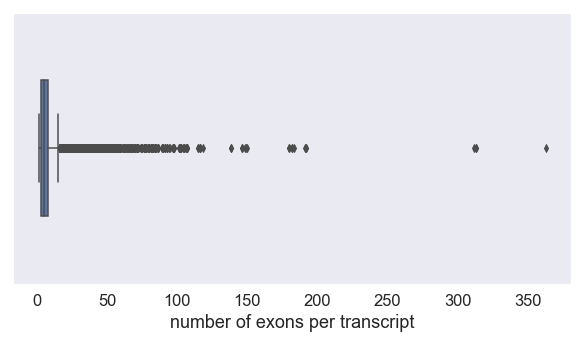

In [71]:
fig, axes = plt.subplots(figsize=(10,5))
sns.boxplot(nums_exons_per_trans, width=0.5, ax = axes)
axes.set_xlabel('number of exons per transcript')

In [50]:
np.average(nums_exons_per_trans)

7.245608049298472

Understand number of transcripts per gene

In [51]:
unique_gene_ids, gene_indexes = np.unique(trans_only_data.gene_id, return_index=True)
#prepared for sorting indexes
merged_table = pd.DataFrame(unique_gene_ids, index = gene_indexes)
merged_table.sort_index(inplace= True)
gene_ids = np.array(merged_table[0])

In [52]:
#select GENCODE protein-coding genes on one table
gencode_genes = gencode_data[gencode_data.feature=='gene']

In [53]:
nums_trans_per_gene = []
for id_tag in gene_ids:
    num_trans = transcript_ovl_result\
    [transcript_ovl_result.gene_id==id_tag].shape[0]
    nums_trans_per_gene.append(num_trans)
#gencode_only_protein_coding_genes['num_trans'] = nums_trans_per_gene

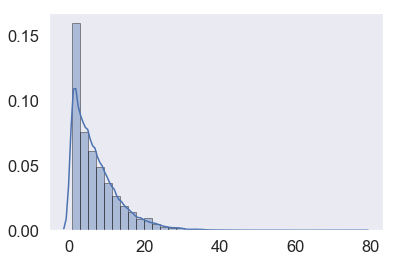

In [54]:
sns.distplot(nums_trans_per_gene, hist_kws={'edgecolor':'black'}, bins = int(180/5))

Text(0.5, 0, 'number of transcripts per gene')

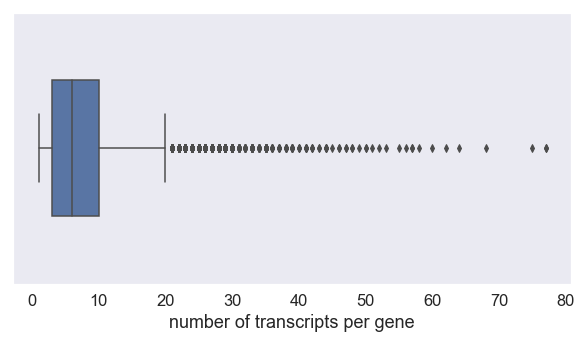

In [73]:
fig, axes = plt.subplots(figsize=(10,5))
sns.boxplot(nums_trans_per_gene, width=0.5, ax = axes)
axes.set_xlabel('number of transcripts per gene')

In [56]:
np.max(nums_trans_per_gene)

77

Protein coding gentype on gencode

In [14]:
def unique_unsorted_elements(array):
    array = np.copy(array)
    unique_elements, indexes = np.unique(array, return_index=True)
    #prepared for sorting indexes
    merged_table = pd.DataFrame(unique_elements, index = indexes)
    merged_table.sort_index(inplace= True)
    unique_unsorted_elements = np.array(merged_table[0])
    return unique_unsorted_elements

def compare_gencode_chr_portion(capture_list, gencode_table, chr_name):
    #return gencode data with dropping unsatisfied data points
    capture_chr_list = capture_list[capture_list[0]==chr_name]
    #print(capture_chr_list)
    capture_chr_list.sort_values(capture_chr_list.columns[1], axis = 0, inplace= True)
    capture_chr_list.reset_index(drop= True, inplace = True)
    gencode_chr_portion = gencode_table[gencode_table.seqname==chr_name]
    gencode_range_array = np.array([gencode_chr_portion.start,\
                                   gencode_chr_portion.end]).T
    #print(gencode_range_array)
    ovl_indexes, percents_ovl = search_overlap_partners(np.array(capture_chr_list[[1,2]]),gencode_range_array)
    #reset_ovl_indexes = np.array(gencode_chr_portion.index)[ovl_indexes]
    #print(ovl_indexes)
    #print(len(ovl_indexes)-len(gencode_table))
    non_ovl_indexes = np.delete(np.array(gencode_chr_portion.index), ovl_indexes, None) #delete portion of array that has the index
    #print(non_ovl_indexes)
    gencode_table.drop(index = non_ovl_indexes, inplace= True)
    return gencode_table

def compare_gencode_chr_portion_wo_capture(ref_list, gencode_table, chr_name):
    #return gencode data with dropping unsatisfied data points
    ref_chr_list = ref_list[ref_list.seqname==chr_name]
    #print(capture_chr_list)
    ref_chr_list.sort_values(by = ['start'], axis = 0, inplace= True)
    ref_chr_list.reset_index(drop= True, inplace = True)
    gencode_chr_portion = gencode_table[gencode_table.seqname==chr_name]
    gencode_range_array = np.array([gencode_chr_portion.start,\
                                   gencode_chr_portion.end]).T
    #print(gencode_range_array)
    ovl_indexes, percents_ovl = search_overlap_partners(np.array([ref_chr_list.start, ref_chr_list.end]).T,\
                                                        gencode_range_array)
    #reset_ovl_indexes = np.array(gencode_chr_portion.index)[ovl_indexes]
    #print(ovl_indexes)
    #print(len(ovl_indexes)-len(gencode_table))
    non_ovl_indexes = np.delete(np.array(gencode_chr_portion.index), ovl_indexes, None) #delete portion of array that has the index
    #print(non_ovl_indexes)
    gencode_table.drop(index = non_ovl_indexes, inplace= True)
    return gencode_table

In [12]:
#check if any UTRs in CAPTURE:
UTR_regions = gencode_data[(gencode_data.feature=='UTR') & (gencode_data.gene_type=='protein_coding')]
UTR_regions.head()

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_status,transcript_name,tag,transcript_support_level,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
59,chr1,HAVANA,UTR,70006,70008,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,,,,ENSP00000334393.3,CCDS30547.1
138,chr1,ENSEMBL,UTR,182393,182708,NaN,+,0,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.3-201,"basic,appris_principal_1",1,,,,,ENSP00000485457.1,
139,chr1,ENSEMBL,UTR,184156,184158,NaN,+,0,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.3-201,"basic,appris_principal_1",1,,,,,ENSP00000485457.1,
164,chr1,ENSEMBL,UTR,184923,185219,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-201,"basic,appris_alternative_2",5,,,,,ENSP00000485222.1,
190,chr1,ENSEMBL,UTR,184925,185219,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-202,"basic,appris_principal_5",5,,,,,ENSP00000485442.1,


In [45]:
#ordered by gencode:
chr_names = unique_unsorted_elements(np.array(UTR_regions.seqname))

In [46]:
UTR_regions_in_CAPTURE = pd.DataFrame.copy(UTR_regions)
#set(UTR_regions_in_CAPTURE.seqname)
for name in chr_names:
    UTR_regions_in_CAPTURE = compare_gencode_chr_portion(capture_data, UTR_regions_in_CAPTURE, name)
UTR_regions_in_CAPTURE.shape
#no UTR regions found in capture

/Users/ndnguyen20/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(216034, 26)

In [47]:
UTR_regions_in_CAPTURE.shape[0]/UTR_regions.shape[0]

0.7828112996970708

In [48]:
#check if start codons in CAPTURE:
start_codons= gencode_data[(gencode_data.feature=='start_codon') & (gencode_data.gene_type=='protein_coding')]
start_codons.head()

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_status,transcript_name,tag,transcript_support_level,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
57,chr1,HAVANA,start_codon,69091,69093,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,1,ENSE00002319515.1,,ENSP00000334393.3,CCDS30547.1
132,chr1,ENSEMBL,start_codon,182709,182711,NaN,+,0,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.3-201,"basic,appris_principal_1",1,,1,ENSE00003759020.1,,ENSP00000485457.1,
144,chr1,ENSEMBL,start_codon,195409,195411,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-201,"basic,appris_alternative_2",5,,1,ENSE00003758618.1,,ENSP00000485222.1,
168,chr1,ENSEMBL,start_codon,195409,195411,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-202,"basic,appris_principal_5",5,,1,ENSE00003755778.1,,ENSP00000485442.1,
194,chr1,ENSEMBL,start_codon,200084,200086,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-203,"basic,appris_alternative_2",5,,1,ENSE00003757911.1,,ENSP00000485351.1,


In [49]:
start_codons_in_CAPTURE = pd.DataFrame.copy(start_codons)
for name in chr_names:
    start_codons_in_CAPTURE = compare_gencode_chr_portion(capture_data,start_codons_in_CAPTURE, name)
start_codons_in_CAPTURE.shape[0]/start_codons.shape[0]

/Users/ndnguyen20/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


0.985237687889527

In [50]:
stop_codons= gencode_data[(gencode_data.feature=='stop_codon') & (gencode_data.gene_type=='protein_coding')]
stop_codons.head()

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_status,transcript_name,tag,transcript_support_level,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
58,chr1,HAVANA,stop_codon,70006,70008,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,1,ENSE00002319515.1,,ENSP00000334393.3,CCDS30547.1
137,chr1,ENSEMBL,stop_codon,184156,184158,NaN,+,0,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.3-201,"basic,appris_principal_1",1,,3,ENSE00003760199.1,,ENSP00000485457.1,
163,chr1,ENSEMBL,stop_codon,185217,185219,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-201,"basic,appris_alternative_2",5,,10,ENSE00003758954.1,,ENSP00000485222.1,
189,chr1,ENSEMBL,stop_codon,185217,185219,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-202,"basic,appris_principal_5",5,,11,ENSE00003755076.1,,ENSP00000485442.1,
223,chr1,ENSEMBL,stop_codon,184927,184929,NaN,-,0,ENSG00000279457.2,protein_coding,...,KNOWN,FO538757.2-203,"basic,appris_alternative_2",5,,15,ENSE00003759031.1,,ENSP00000485351.1,


In [51]:
stop_codons_in_CAPTURE = pd.DataFrame.copy(stop_codons)
for name in chr_names:
    stop_codons_in_CAPTURE = compare_gencode_chr_portion(capture_data, stop_codons_in_CAPTURE, name)
stop_codons_in_CAPTURE.shape[0]/stop_codons.shape[0]

/Users/ndnguyen20/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


0.9419801205712975

Quick search how many UTRs are stop codons

In [54]:
stop_codons.reset_index(drop= True, inplace= True)

In [57]:
UTR_regions_in_stop_codons = pd.DataFrame.copy(UTR_regions)
for name in chr_names:
    UTR_regions_in_stop_codons = compare_gencode_chr_portion_wo_capture(stop_codons, UTR_regions_in_stop_codons, name)
UTR_regions_in_stop_codons.shape[0]/UTR_regions.shape[0]

/Users/ndnguyen20/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.32062310669198324

Making sure CAPTURE exons do not overlap each other:

In [177]:

for name in chr_names:
    capture_check = detect_collapse_hg38_exons(CAPTURE_dict_chr[name])
    capture_check.sort_values(1, inplace= True)
    capture_check.reset_index(drop= True, inplace= True)

#--> we have a hundred of those having alternative haplotypes that collapse into a single exon
# no end-to-end touching

/Users/ndnguyen20/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


chr1
[]
chr2
[]
chr3
[]
chr4
[]
chr5
[]
chr6
[]
chr7
[]
chr8
[]
chr9
[]
chr10
[]
chr11
[]
chr12
[]
chr13
[]
chr14
[]
chr15
[]
chr16
[]
chr17
[]
chr18
[]
chr19
[]
chr20
[]
chr21
[]
chr22
[]
chrX
[]
chrY
[]
chrM
[]


In [15]:
gencode_protein_coding_gene = gencode_data[(gencode_data.gene_type=='protein_coding')]
gencode_protein_coding_gene.head()

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_status,transcript_name,tag,transcript_support_level,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
53,chr1,HAVANA,gene,69091,70008,NaN,+,0,ENSG00000186092.4,protein_coding,...,,,,,,,,,,
54,chr1,HAVANA,transcript,69091,70008,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,,,,ENSP00000334393.3,CCDS30547.1
55,chr1,HAVANA,exon,69091,70008,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,1,ENSE00002319515.1,,ENSP00000334393.3,CCDS30547.1
56,chr1,HAVANA,CDS,69091,70005,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,1,ENSE00002319515.1,,ENSP00000334393.3,CCDS30547.1
57,chr1,HAVANA,start_codon,69091,69093,NaN,+,0,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,"basic,appris_principal_1,CCDS",NA,OTTHUMT00000003223.1,1,ENSE00002319515.1,,ENSP00000334393.3,CCDS30547.1


make sure GENCODE exons do overlap each other per gene:

Report fractions of genes found in CAPTURE.

In [16]:
#Copy and modify from GENCODE_CAPTURE_matching.ipynb
def percent_difference(reference, range_ovl):
    reference = np.copy(reference)
    range_ovl = np.copy(range_ovl)
    rd = (min(reference[1], range_ovl[1])-max(reference[0], range_ovl[0])+1)/(reference[1]-reference[0]+1)
    return rd
def range_difference(range1, range2):
    range1 = np.copy(range1)
    range2 = np.copy(range2)
    rd = min(range1[1], range2[1])-max(range1[0], range2[0])+1
    return rd
def search_overlap_partners(chr_ref, chr_search, return_indexes = False):
    """reform the search function"""
    chr_ref = np.copy(chr_ref)
    chr_search = np.copy(chr_search)
    search_indexes = []
    ref_indexes = []
    p_refs=[]
    ranges_ovl = np.array([0])

    for i in range(chr_search.shape[0]):
        
        p_search = chr_search[i]
        closest_ref_val = np.argwhere(chr_ref[:,0]-p_search[0]<0)
        if closest_ref_val.size > 0:
            ref_i = np.max(closest_ref_val) #lower start of ref closest to start of search 
            p_ref = chr_ref[ref_i]
        else:

            ref_i = 0 #just to make sure
            p_ref = chr_ref[ref_i]
            #not to let the ref pass over:
        while ((max(p_ref[0], p_search[0])-min(p_ref[1], p_search[1]))>0) and (p_ref[0]<p_search[1]) and (ref_i < len(chr_ref)):



            ref_i += 1
            if ref_i <len(chr_ref):
                p_ref = chr_ref[ref_i]

        #Just to make sure a search is matched with all ref
        while (p_search[1]>p_ref[0]) and (ref_i <len(chr_ref)):
            if ((min(p_ref[1], p_search[1])-max(p_ref[0], p_search[0]))>0):

                if i not in search_indexes:
                    #print(p_search, p_ref)
                    ranges_ovl= np.append(ranges_ovl, \
                                          range_difference(p_search, p_ref)) #percent of search being overlapped
                search_indexes.append(i)
                ref_indexes.append(ref_i)
                p_refs.append(p_ref.tolist())
            ref_i+=1
            if ref_i <len(chr_ref):
                p_ref= chr_ref[ref_i]

            
    if len(p_refs)>0: 
        unique_p_refs = np.unique(p_refs, axis = 0)

        num_refs_ovl = unique_p_refs.shape[0]
        if unique_p_refs.shape[0] > 1:
            ranges_ref_ovl = unique_p_refs[:,1]- unique_p_refs[:,0]+1
        else:

            ranges_ref_ovl = np.array(unique_p_refs[0][1]-unique_p_refs[0][0]+1)
    else:
        num_refs_ovl = 0
        ranges_ref_ovl = np.array([], dtype=int)

    if return_indexes:
        return ref_indexes, search_indexes
    else:
        return ranges_ovl, num_refs_ovl, ranges_ref_ovl

In [17]:
gene_collection = unique_unsorted_elements(gencode_protein_coding_gene.gene_name)

In [18]:
def temporary_table(a =0):
    return pd.DataFrame(columns=[['gene_name','gene_id','#TX','#CAP_exons','#CAP_bases',\
                                            '#GC_exons','#GC_bases','%bases_ovl','%UTR_bases_ovl','%exon_bases_ovl']])
def merge_ranges(ls):
    ls = np.copy(ls)
    ls = ls[np.argsort(ls, axis = 0)[:,0]]
    ovl_list =[]
    for i in range(1,ls.shape[0]):
        if (ls[i,0] < ls[i-1,1]):
            ls[i,0] = np.min(ls[i-1:i+1,0])
            ls[i,1] = np.max(ls[i-1:i+1,1])
            ovl_list.append(i-1)
    refined_list = np.delete(ls, ovl_list, 0)
    return refined_list


def remove_ranges(ls, ls2rm, with_indexes = False):

    ls = np.copy(ls)
    ls2rm = np.copy(ls2rm)
    ls_ovl_indexes,ls2rm_ovl_indexes = search_overlap_partners(ls, ls2rm,return_indexes=True)
    #print(search_overlap_partners(ls, ls2rm,return_indexes=True))
    del_indexes = []
    remain_indexes = []
    for i in range(len(ls_ovl_indexes)):
        ovl_region = np.array([np.max([ls[ls_ovl_indexes[i], 0], ls2rm[ls2rm_ovl_indexes[i],0]]),\
                               np.min([ls[ls_ovl_indexes[i], 1], ls2rm[ls2rm_ovl_indexes[i], 1]])])
        if (ovl_region[1]-ovl_region[0])==(ls[ls_ovl_indexes[i], 1] - ls[ls_ovl_indexes[i], 0]):
            del_indexes.append(i)
            #print('UTR fl')
        elif ovl_region[1] < ls[ls_ovl_indexes[i],1]:
            remain_indexes.append(i)
            ls[ls_ovl_indexes[i],0] = ovl_region[1]+1
        elif ovl_region[0]>ls[ls_ovl_indexes[i],0]:
            remain_indexes.append(i)
            ls[ls_ovl_indexes[i],1] = ovl_region[0]-1
        else:
            raise ValueError('UTR found inside coding regions')
    #print(ls_ovl_indexes[del_indexes])
    ls = np.delete(ls, np.array(ls_ovl_indexes)[del_indexes], 0)
    #print(ls)
    if with_indexes:
        return ls, remain_indexes
    else:
        return ls

def mid_exons_search(gencode_gene_data):
    #keep true internal exons intact
    tx_list = unique_unsorted_elements(gencode_gene_data.transcript_id)
    mid_exons = np.empty([1,2], dtype=int)
    for tx_id in tx_list:
        if gencode_gene_data[(gencode_gene_data.transcript_id == tx_id) &\
                    (gencode_gene_data.feature == 'UTR')].shape[0] > 0.:
            exon_list = gencode_gene_data[(gencode_gene_data.transcript_id == tx_id) &\
                        (gencode_gene_data.feature == 'exon')]
            exon_list = np.array(exon_list[['start','end']])
            exon_list = exon_list[np.argsort(exon_list, axis = 0)[:,0]]
            
            mid_exon_point = np.average([np.min(exon_list[:,0]), np.max(exon_list[:,1])]) # sure fall at middle of exon seq
            UTR_list = gencode_gene_data[(gencode_gene_data.transcript_id == tx_id) &\
                    (gencode_gene_data.feature == 'UTR')]
            UTR_list = np.array(UTR_list[['start','end']])
            UTR_list = UTR_list[np.argsort(UTR_list, axis=0)[:,0]]
            # classify 3' and 5' UTRs
            UTRs_5_prime = UTR_list[UTR_list[:,0]<mid_exon_point]
            UTRs_3_prime = UTR_list[UTR_list[:,1]> mid_exon_point]
            if UTRs_5_prime.shape[0]==0:
                UTRs_5_prime = np.array([[np.inf,np.inf]])
            if UTRs_3_prime.shape[0] == 0:
                UTRs_3_prime = np.array([[-np.inf,-np.inf]])

            mid_exon_bounds = np.array([np.max(UTRs_5_prime[:,1]), np.min(UTRs_3_prime[:,0])])
            mid_exons = np.append(mid_exons, exon_list[(exon_list[:,0]>mid_exon_bounds[0]) &\
                                                        (exon_list[:,1]<mid_exon_bounds[1])], axis = 0)
    mid_exons = np.delete(mid_exons,0, axis=0)
    mid_exons = merge_ranges(mid_exons)
    return mid_exons
            
        
        
def non_matching_exon_UTRs_search(exons, UTRs, *args):
    #NME for non matching exon
    #take the coordinates of ending exons
    exons = np.copy(exons)
    UTRs = np.copy(UTRs)
    gencode_gene_data = pd.DataFrame.copy(args[0])
    
    final_exon_ends = [exons[0,1], exons[-1,0]]
    #print(final_exon_ends)
    otm_UTRs = np.append(UTRs[(UTRs[:,1]<=final_exon_ends[0])], UTRs[(UTRs[:,0]>=final_exon_ends[1])],axis=0) #outermost UTRs
    #print(otm_UTRs)
    #print(otm_UTRs)
    mid_UTRs = np.array([UTRs[i] for i in range(UTRs.shape[0]) if UTRs[i,0] not in otm_UTRs[:,0]])
    mid_exons = mid_exons_search(gencode_gene_data) #args_0 for gencode_gene_data
    if mid_UTRs.shape[0]>0:
        UTR_ME_indexes, check = search_overlap_partners(mid_UTRs, mid_exons, return_indexes= True)
        NME_UTRs = np.delete(mid_UTRs, UTR_ME_indexes, axis= 0)
        NME_UTRs = np.append(otm_UTRs, NME_UTRs, axis = 0)
        NME_UTRs = merge_ranges(NME_UTRs)
    else:
        NME_UTRs = otm_UTRs
    #print(NME_UTRs)
    return NME_UTRs
    
def info_per_gene(gencode_table, capture_list, gene_name):
    gencode_table = pd.DataFrame.copy(gencode_table)
    capture_list = pd.DataFrame.copy(capture_list)
    temp_table = temporary_table()
    #deal with individual gene
    gencode_gene_data = gencode_table[gencode_table.gene_name ==gene_name]
    chr_name = unique_unsorted_elements(gencode_gene_data.seqname)[0]
    gene_id = unique_unsorted_elements(gencode_gene_data.gene_id)[0]
    
    #after hg38 capture exons are no longer overlapping
    #prep capture_list
    capture_chr_data = pd.DataFrame.copy(capture_list[capture_list[0]==chr_name])
    capture_chr_data.sort_values(1, axis=0, inplace= True)
    capture_chr_data = np.array(capture_chr_data[[1,2]])
    
    #bases (exons+UTRs)
    gencode_bases_data = gencode_gene_data[(gencode_gene_data.feature=='exon') | (gencode_gene_data.feature=='UTR')]
    gencode_bases_data = np.array(gencode_bases_data[['start','end']])
    gencode_bases_data = gencode_bases_data[np.argsort(gencode_bases_data, axis = 0)[:,0]]
    #merging bases:
    gencode_bases_data = merge_ranges(gencode_bases_data)
    
    #exons (before removing UTRs)
    gencode_exons_data = gencode_gene_data[(gencode_gene_data.feature=='exon')]
    gencode_exons_data = np.array(gencode_exons_data[['start','end']])
    gencode_exons_data = gencode_exons_data[np.argsort(gencode_exons_data, axis = 0)[:,0]]
    gencode_exons_data = merge_ranges(gencode_exons_data)
    
    #non-exon-matching UTRs (NEM UTRs)
    gencode_UTRs_data = gencode_gene_data[gencode_gene_data.feature == 'UTR']
    if gencode_UTRs_data.shape[0]>0:
        #detect ovl UTR
        gencode_UTRs_data.sort_values(by = 'start', axis=0, inplace= True)
        gencode_UTRs_data = np.array(gencode_UTRs_data[['start','end']])
        gencode_UTRs_data = merge_ranges(gencode_UTRs_data)
        gencode_NEM_UTRs_data = non_matching_exon_UTRs_search(gencode_exons_data, gencode_UTRs_data,\
                                                             gencode_gene_data) 
        
        #remove UTRs that does have any matches with exons to get exons only

        gencode_exons_data = remove_ranges(gencode_exons_data, gencode_NEM_UTRs_data)
        #% non-exon-matching UTRs:
        UTR_ranges_ovl, num_cap_ovl_UTRs, ranges_cap_ovl_UTR = search_overlap_partners(capture_chr_data,\
                                                                                       gencode_NEM_UTRs_data)
        total_UTR_bases = np.sum(gencode_NEM_UTRs_data[:,1] -gencode_NEM_UTRs_data[:,0] +1)
        total_UTR_ovl_bases = np.sum(UTR_ranges_ovl)
        percent_UTR_bases_ovl = total_UTR_ovl_bases/total_UTR_bases
    else:
        percent_UTR_bases_ovl = np.nan
    
    # % bases ovl:
    bases_ranges_ovl, num_cap_ovl_bases, ranges_cap_ovl_bases = search_overlap_partners(capture_chr_data, gencode_bases_data)
    total_GC_bases = np.sum(gencode_bases_data[:,1]- gencode_bases_data[:,0] +1) #not only those ovl
    total_GC_ovl_bases = np.sum(bases_ranges_ovl)
    
    # % exons ovl:
    exons_ranges_ovl, num_cap_ovl_exons, ranges_cap_ovl_exons = search_overlap_partners(capture_chr_data, gencode_exons_data)
    total_GC_exons = np.sum(gencode_exons_data[:,1]- gencode_exons_data[:,0] +1) #not only those ovl
    total_GC_ovl_exons = np.sum(exons_ranges_ovl)
    temp_table['gene_name'] = [gene_name]
    temp_table['gene_id'] = [gene_id]
    temp_table['#TX'] = [gencode_gene_data[gencode_gene_data.feature == 'transcript'].shape[0]]
    temp_table['#GC_exons'] = [gencode_exons_data.shape[0]]
    temp_table['#GC_bases'] = [total_GC_bases]
    temp_table['#CAP_exons'] = [num_cap_ovl_bases]
    temp_table['%UTR_bases_ovl'] = [percent_UTR_bases_ovl]
    temp_table['#CAP_bases'] = [np.sum(ranges_cap_ovl_exons)]
    temp_table['%bases_ovl'] = [total_GC_ovl_bases/total_GC_bases]
    temp_table['%exon_bases_ovl'] = [total_GC_ovl_exons/total_GC_exons]
    temp_table['%UTR_bases_ovl'] = percent_UTR_bases_ovl
    return temp_table
    
    

In [23]:
gene_name ='AMER1'
info_per_gene(gencode_protein_coding_gene, capture_data, gene_name = gene_name)

,gene_name,gene_id,#TX,#CAP_exons,#CAP_bases,#GC_exons,#GC_bases,%bases_ovl,%UTR_bases_ovl,%exon_bases_ovl
0,AMER1,ENSG00000184675.8,2,2,3511,1,8443,0.011963,0.030171,1.0


In [77]:
#multiprocessing:
complete_gene_info = pd.DataFrame(columns=[['gene_name','gene_id','#TX','#CAP_exons','#CAP_bases',\
                                            '#GC_exons','#GC_bases','%bases_ovl','%UTR_bases_ovl','%exon_bases_ovl']])
temp_gene_info = pd.DataFrame.copy(complete_gene_info) #temporary table used for updating
gene_func_inputs = {'gencode_table':gencode_protein_coding_gene, \
                    'capture_list': capture_data, 'gene_name':gene_collection}
def multi_gene_func(niter, **kwargs):
    #print(kwargs['gene_name'])
    kwargs['gene_name'] = kwargs['gene_name'][niter]
    time.sleep(1)
    return info_per_gene(**kwargs)
mapfunc = partial(multi_gene_func,**gene_func_inputs)
#pool = multiprocessing.Pool(5)
#pool = multiprocessing.pool.ThreadPool(4)
#outputs = []

with multiprocessing.Pool(3) as p:
      outputs = list(tqdm(p.imap(mapfunc, range(3)), total=3))
#outputs = pool.map(mapfunc, range(len(gene_collection[:100])))
complete_gene_info = pd.concat(outputs)
complete_gene_info.reset_index(drop = True, inplace= True)

#This step finished on terminal python

100%|██████████| 3/3 [00:34<00:00, 11.82s/it]


In [ ]:
#complete_gene_info = pd.concat([complete_gene_info, temp_gene_info])
complete_gene_info.reset_index(drop = True, inplace= True)

In [20]:
complete_gene_info = pd.read_csv('complete_genome_data.txt', sep ="\t")
complete_gene_info.shape

(19712, 10)

In [21]:
complete_gene_info.head()

,gene_name,gene_id,#TX,#CAP_exons,#CAP_bases,#GC_exons,#GC_bases,%bases_ovl,%UTR_bases_ovl,%exon_bases_ovl
0,OR4F5,ENSG00000186092.4,1,1,941,1,918,1.0,1.0,1.0
1,FO538757.3,ENSG00000279928.1,1,0,0,3,718,0.0,0.0,0.0
2,FO538757.2,ENSG00000279457.2,3,0,0,14,1982,0.0,0.0,0.0
3,OR4F29,ENSG00000278566.1,1,1,961,1,939,1.0,1.0,1.0
4,OR4F16,ENSG00000273547.1,1,1,951,1,939,1.0,1.0,1.0


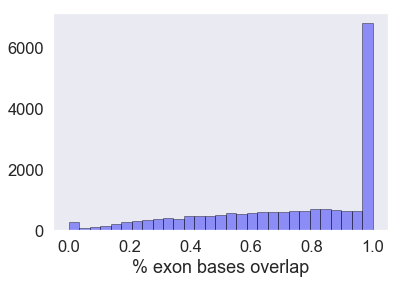

In [27]:
sns.set(style="dark", color_codes=True, font_scale=1.5)
sns.distplot(complete_gene_info['%exon_bases_ovl'].dropna(), hist=True, kde=False, color = 'blue',\
             hist_kws={'edgecolor':'black'}, norm_hist= False, axlabel='% exon bases overlap')


remove 2-end exon portions/ exons that are UTR

In [293]:
#gencode_protein_coding_gene_rm_UTRexons.loc[55].seqname.fill('chrDMM')
gencode_protein_coding_gene_rm_UTRexons.loc[55]=\
gencode_protein_coding_gene_rm_UTRexons.loc[55].replace('chr1','chrDMM')

In [31]:
#make tracker for testing genes
gencode_protein_coding_gene[(gencode_protein_coding_gene.gene_name=='EPAS1')\
                            & (gencode_protein_coding_gene.feature=='exon')]\
[['seqname', 'start', 'end']].to_csv('sample_EPAS1_exon_track.txt', index=None, sep='\t', header = None)

In [155]:
complete_gene_info.to_csv('complete_genome_data.txt', index=None, sep='\t')